# Housing Days On Market - Unsupervised Model Selection

## Information

Housing related data sources were combined in the project SQLite database. The output CSV file is analyzed here. 

### Environment Information:

Environment used for coding is as follow:

Oracle VM VirtualBox running Ubuntu (guest) on Windows 10 (host).

Current conda install:

               platform : linux-64
          conda version : 4.2.13
       conda is private : False
      conda-env version : 4.2.13
    conda-build version : 1.20.0
         python version : 2.7.11.final.0
       requests version : 2.9.1
       default environment : /home/jonathan/anaconda2/envs/py35
       
       Python 3.5.2 :: Anaconda 4.1.1 (64-bit)

Package requirements:

dill : 0.2.5, numpy : 1.11.3, pandas : 0.18.1, matplotlib : 1.5.1, scipy : 0.18.1, seaborn : 0.7.1, scikit-image : 0.12.3, scikit-learn : 0.18.1

## Python Package(s) Used

In [1]:
import dill
import numpy as np
import pandas as pd
import time

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

In [4]:
%matplotlib inline

In [5]:
plt.style.use('seaborn-whitegrid')

## Data and Methods

### Data Fetching

In [6]:
# Import data csv into dataframe
df = pd.read_csv('df_prep_for_feature_selection_output.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,ListPrice2,Bedrooms,BathsFull,BathsHalf,Levels,Fireplaces,BasementY/N,Acres,YearBuilt,DOMP,...,HSSR_1.0,HSSR_2.0,HSSR_3.0,HSSR_4.0,MSSR_0.0,MSSR_1.0,MSSR_2.0,MSSR_3.0,MSSR_4.0,MSSR_5.0
0,269900,3,2,0.0,3,0,1,0.082,1950,10,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,255000,2,2,1.0,2,1,0,0.000,1987,41,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,299900,1,1,0.0,1,0,0,0.000,1941,12,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,245000,1,1,0.0,1,0,0,0.000,1941,16,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,250000,1,1,0.0,1,0,0,0.000,1891,5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Cluster Modelling

### Node Selection

In [7]:
df_2 = df.copy()

In [8]:
# Performing feature selection on full dataset, resulted in best_score ~ 0.1.
# Qcutting to separate out data.
# qcut value = 1 is dataset as is.

# Qcut DOMP target data
df_2['qcut_DOMP'] = pd.qcut(df_2['DOMP'], 1, labels = False)
# Print out total row counts for each group
print(df_2['qcut_DOMP'].value_counts())
# Select specific range
df_2 = df_2[df_2['qcut_DOMP'] == 0]
# Save dataframe to disk
df_2.to_csv('df_unsupervised_modelling_save_point.csv')

0    13725
Name: qcut_DOMP, dtype: int64


In [9]:
# Copy dataframe for dropping columns and determining categorical columns
df_3 = df_2.copy()
# Drop target column and qcut column
df_3 = df_3.drop('DOMP', axis=1)
df_3 = df_3.drop('qcut_DOMP', axis=1)
X = df_3

In [ ]:
# Checking for grouped categorical columns
#df_3.columns[89:167]

In [ ]:
# Columns that are not scaled since they are categorical
# cat_df = df_3[[u'BasementY/N']]
# cat_df_2 = df_3.ix[:,34:38]
# cat_df_3 = df_3.ix[:,43:47]
# cat_df_4 = df_3.ix[:,52:56]
# cat_df_5 = df_3.ix[:,89:167]
# CATEGORICAL = pd.concat([cat_df,cat_df_2,cat_df_3,cat_df_4,cat_df_5],axis=1)

In [10]:
CATEGORICAL = ['BasementY/N','ES_IsCharter','ES_IsMagnet','ES_IsTitleI','ES_IsVirtual',
               'HS_IsCharter','HS_IsMagnet','HS_IsTitleI','HS_IsVirtual','MS_IsCharter',
               'MS_IsMagnet','MS_IsTitleI','MS_IsVirtual','zip_20001','zip_20002','zip_20004',
               'zip_20005','zip_20007','zip_20008','zip_20009','zip_20010','zip_20011',
               'zip_20012','zip_20015','zip_20017','zip_20018','zip_20019','zip_20020',
               'zip_20032','zip_20036','zip_20037','ldmonth_1','ldmonth_2','ldmonth_3',
               'ldmonth_4','ldmonth_5','ldmonth_6','ldmonth_7','ldmonth_8','ldmonth_9',
               'ldmonth_10','ldmonth_11','ldmonth_12','ldday_1','ldday_2','ldday_3',
               'ldday_4','ldday_5','ldday_6','ldday_7','ldday_8','ldday_9','ldday_10',
               'ldday_11','ldday_12','ldday_13','ldday_14','ldday_15','ldday_16','ldday_17',
               'ldday_18','ldday_19','ldday_20','ldday_21','ldday_22','ldday_23','ldday_24',
               'ldday_25','ldday_26','ldday_27','ldday_28','ldday_29','ldday_30','ldday_31',
               'ESSR_0.0','ESSR_1.0','ESSR_2.0','ESSR_3.0','ESSR_4.0','ESSR_5.0','HSSR_0.0',
               'HSSR_1.0','HSSR_2.0','HSSR_3.0','HSSR_4.0','MSSR_0.0','MSSR_1.0','MSSR_2.0',
               'MSSR_3.0','MSSR_4.0','MSSR_5.0']

In [11]:
# Scaling data
for i in X.columns.difference(CATEGORICAL):
    X[i] = StandardScaler().fit_transform(X[i].values.reshape(-1,1))

/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [12]:
X.head()

,ListPrice2,Bedrooms,BathsFull,BathsHalf,Levels,Fireplaces,BasementY/N,Acres,YearBuilt,TotalTaxes2,...,HSSR_1.0,HSSR_2.0,HSSR_3.0,HSSR_4.0,MSSR_0.0,MSSR_1.0,MSSR_2.0,MSSR_3.0,MSSR_4.0,MSSR_5.0
0,-0.543487,0.162356,0.026016,-0.798325,0.496749,-0.651581,1,0.344863,0.193616,-0.377620,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.565704,-0.536400,0.026016,0.864852,-0.329060,0.406756,0,-0.662579,1.328753,-0.392927,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.498755,-1.235156,-0.941665,-0.798325,-1.154870,-0.651581,0,-0.662579,-0.082498,-0.470453,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.580614,-1.235156,-0.941665,-0.798325,-1.154870,-0.651581,0,-0.662579,-0.082498,-0.565672,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.573159,-1.235156,-0.941665,-0.798325,-1.154870,-0.651581,0,-0.662579,-1.616467,-0.580979,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


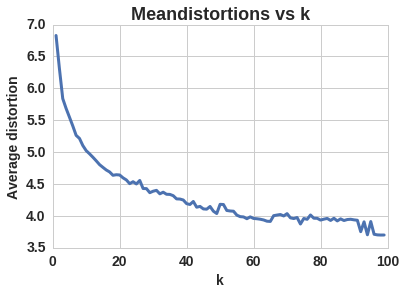


Build and Validation took 66.852 seconds



In [13]:
# Code adapted from https://www.packtpub.com/books/content/clustering-k-means

# Start clock for run time
start = time.time()

# Define variables
K = range(1,100)
meandistortions = []

for k in K:
    elbow = MiniBatchKMeans(n_clusters=k, random_state=1)
    elbow.fit(X)
    meandistortions.append(sum(np.min(euclidean_distances(X, elbow.cluster_centers_), axis=1)) / X.shape[0])
    
# Plot Mean Distortions vs k    
plt.plot(K, meandistortions,linewidth=3)
plt.title('Meandistortions vs k',fontsize=18,fontweight='bold')
plt.xlabel('k',fontsize=14,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.ylabel('Average distortion',fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.legend(fontsize=16)
plt.savefig('k_elbow_minibatchkmeans_plot')
plt.show()

# Print run time
print("\nBuild and Validation took {:0.3f} seconds\n".format(time.time()-start))

### Plot shows that there may be >=20 clusters!

In [ ]:
# Silhouette scores are very memory intensive. Have to do one at a time...

# Determine silhouette_score for number of clusters from elbow plot
kmeans = MiniBatchKMeans(n_clusters=20, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_
print(silhouette_score(X, labels, metric='euclidean'))

In [ ]:
# Code adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silhouette_plot(X, range_n_clusters = range(2, 12, 2)):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.ix[:, 0], X.ix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [ ]:
silhouette_plot(X)